In [ ]:
!pip -y uninstall tensorflow
!pip install tensorflow==2.12.0


Usage:   
  pip3 <command> [options]

no such option: -y
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 104.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━

In [ ]:
#Librerias
import os
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
print(tf.__version__)
import tensorflow_hub as hub
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib

2.12.0


In [ ]:
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
#Crear la carpeta
%cd /content/gdrive/MyDrive/
!mkdir ML_entrenamiento

/content/gdrive/MyDrive
mkdir: cannot create directory ‘ML_entrenamiento’: File exists


In [ ]:
#desempaquear los archivos
%cd /content/gdrive/MyDrive/ML_entrenamiento
!unzip /content/gdrive/MyDrive/ML_entrenamiento/dataset.zip -d .

/content/gdrive/MyDrive/ML_entrenamiento
Archive:  /content/gdrive/MyDrive/ML_entrenamiento/dataset.zip
   creating: ./a/
  inflating: ./a/a1.jpg              
  inflating: ./a/a10.jpg             
  inflating: ./a/a11.jpg             
  inflating: ./a/a12.jpg             
  inflating: ./a/a13.jpg             
  inflating: ./a/a14.jpg             
  inflating: ./a/a15.jpg             
  inflating: ./a/a16.jpg             
  inflating: ./a/a17.jpg             
  inflating: ./a/a18.jpg             
  inflating: ./a/a19.jpg             
  inflating: ./a/a2.jpg              
  inflating: ./a/a20.jpg             
  inflating: ./a/a21.jpg             
  inflating: ./a/a22.jpg             
  inflating: ./a/a23.jpg             
  inflating: ./a/a24.jpg             
  inflating: ./a/a25.jpg             
  inflating: ./a/a26.jpg             
  inflating: ./a/a27.jpg             
  inflating: ./a/a28.jpg             
  inflating: ./a/a29.jpg             
  inflating: ./a/a3.jpg              
  in

In [ ]:
#Generar aumentos de datos
datage = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 10,
    zoom_range = [0.8,1.2],
    validation_split = 0.25 # porcentaje de validacion
)

In [ ]:
#dividir el dataset
path = "/content/gdrive/MyDrive/ML_entrenamiento/"
data_gen_entrenamiento = datage.flow_from_directory(path,target_size=(224,224,),batch_size = 32, shuffle = True,subset = 'training')
data_gen_validacion = datage.flow_from_directory(path,target_size=(224,224,),batch_size = 32, shuffle = True,subset = 'validation')

Found 99 images belonging to 2 classes.
Found 32 images belonging to 2 classes.


In [ ]:
num_class = len(data_gen_entrenamiento.class_indices)
num_class

2

In [ ]:
path_model ="https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"
base = hub.KerasLayer(path_model, trainable=True)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer((224,224,3)),
    base,
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(
        num_class,
        kernel_regularizer=tf.keras.regularizers.l2(1e-4),
        activation='softmax'
    )
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,226,434
Non-trainable params: 34,112
_________________________________________________________________


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.05),
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6
    )
]

In [ ]:
hist = model.fit(
    data_gen_entrenamiento,
    epochs=20,
    validation_data=data_gen_validacion,
    callbacks=callbacks
).history


Epoch 1/20
4/4 [==============================] - 42s 6s/step - loss: 0.5666 - accuracy: 0.7980 - precision: 0.7980 - recall: 0.7980 - val_loss: 1.3671 - val_accuracy: 0.4688 - val_precision: 0.4688 - val_recall: 0.4688 - lr: 1.0000e-04
Epoch 2/20
4/4 [==============================] - 23s 5s/step - loss: 0.2481 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - val_loss: 1.0444 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000 - lr: 1.0000e-04
Epoch 3/20
4/4 [==============================] - 23s 7s/step - loss: 0.2471 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - val_loss: 0.8094 - val_accuracy: 0.5938 - val_precision: 0.5938 - val_recall: 0.5938 - lr: 1.0000e-04
Epoch 4/20
4/4 [==============================] - 23s 5s/step - loss: 0.2460 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - val_loss: 0.5660 - val_accuracy: 0.6875 - val_precision: 0.6875 - val_recall: 0.6875 - lr: 1.0000e-04
Epoch 5/20
4/4 [==============================] - 22

In [ ]:
class_names = tuple(data_gen_entrenamiento.class_indices)
class_names

('a', 'b')

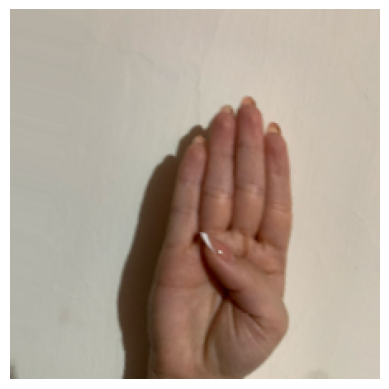

1/1 [==============================] - 0s 59ms/step
Puntuacion: 0.8925957679748535
Etiqueta Predicha: b
Etiqueta Verdadera: b


In [ ]:
x, y = next(iter(data_gen_validacion))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
score = np.max(prediction_scores)
print(f"Puntuacion: {score}")
print("Etiqueta Predicha: " + class_names[true_index])
print("Etiqueta Verdadera: " + class_names[predicted_index])

In [ ]:
path_model = "/content/gdrive/MyDrive/ML_entrenamiento/modelo"
model.save(path_model)

In [ ]:
export_dir = "/content/gdrive/MyDrive/ML_entrenamiento/modelo"

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()
tflite_model_file = pathlib.Path('/content/gdrive/MyDrive/ML_entrenamiento/model.tflite')
tflite_model_file.write_bytes(tflite_model)

4503232

In [ ]:
!pip install tflite_support_nightly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 21.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.8
    Uninstalling protobuf-4.25.8:
      Successfully uninstalled protobuf-4.25.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.
orbax-checkpoint 0.11.13 requires jax>=0.5.0, but you have jax 0.4.30 which is incompatible.
flax 0.10.6 requires jax>=0.5.1, but you have jax 0.4.30 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.12.0 which is incompatible.
ydf 0.12.0 requires protobuf

In [ ]:
import os
file = open("/content/gdrive/MyDrive/ML_entrenamiento/labelmap.txt", "w")
file.write("a" + os.linesep)
file.write("b")
file.close()

In [ ]:
from tflite_support.metadata_writers import image_classifier
from tflite_support.metadata_writers import writer_utils

ImageClassifierWriter = image_classifier.MetadataWriter

_MODEL_PATH = "/content/gdrive/MyDrive/ML_entrenamiento/model.tflite"
_LABEL_FILE = "/content/gdrive/MyDrive/ML_entrenamiento/labelmap.txt"
_SAVE_TO_PATH = "/content/gdrive/MyDrive/ML_entrenamiento/model_meta.tflite"

_INPUT_NORM_MEAN = 127.5
_INPUT_NORM_STD = 127.5

# Create the metadata writer.
writer = ImageClassifierWriter.create_for_inference(
    writer_utils.load_file(_MODEL_PATH), [_INPUT_NORM_MEAN], [_INPUT_NORM_STD], [_LABEL_FILE])

# Verify the metadata generated by metadata writer.
print(writer.get_metadata_json())

# Populate the metadata into the model.
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

{
  "name": "ImageClassifier",
  "description": "Identify the most prominent object in the image from a known set of categories.",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "image",
          "description": "Input image to be classified.",
          "content": {
            "content_properties_type": "ImageProperties",
            "content_properties": {
              "color_space": "RGB"
            }
          },
          "process_units": [
            {
              "options_type": "NormalizationOptions",
              "options": {
                "mean": [
                  127.5
                ],
                "std": [
                  127.5
                ]
              }
            }
          ],
          "stats": {
            "max": [
              1.0
            ],
            "min": [
              -1.0
            ]
          }
        }
      ],
      "output_tensor_metadata": [
        {
          "name": "proba